# **ADZD - lab 5**


## Setup

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xf spark-3.1.2-bin-hadoop3.2.tgz
!pip -q install findspark pyspark graphframes


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
os.environ["HADOOP_HOME"] = os.environ["SPARK_HOME"]

os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.2-spark3.1-s_2.12 pyspark-shell"


import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import graphframes as gf

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)


# pregel
!wget -q https://github.com/graphframes/graphframes/archive/refs/tags/v0.8.2.zip
!unzip -q v0.8.2.zip
!cp "/content/graphframes-0.8.2/python/graphframes/lib/pregel.py" "pregel.py"


!mkdir -p tmp_checkpointdir
sc.setCheckpointDir("tmp_checkpointdir")  # chyba do spójnych składowych potrzebował

     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 57.1 MB/s 
     |████████████████████████████████| 154 kB 14.8 MB/s 


In [3]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pregel import Pregel  # wczytujemy z pliku, to tyle, wywołujemy Pregel(graph)

## **Zadanie nr 1**

Wczytać graf Facebooka, krawędzie z pliku musae_facebook_edges.csv, atrybuty page_name oraz page_type z pliku musae_facebook_target.csv.  Policzyć liczbę krawędzi i wierzchołków. 

In [4]:
!wget https://snap.stanford.edu/data/facebook_large.zip

--2022-12-28 16:22:11--  https://snap.stanford.edu/data/facebook_large.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737479 (1.7M) [application/zip]
Saving to: ‘facebook_large.zip’

facebook_large.zip  100%[===================>]   1.66M  1.12MB/s    in 1.5s    

2022-12-28 16:22:13 (1.12 MB/s) - ‘facebook_large.zip’ saved [1737479/1737479]



In [5]:
!unzip facebook_large.zip

Archive:  facebook_large.zip
   creating: facebook_large/
  inflating: facebook_large/musae_facebook_edges.csv  
  inflating: facebook_large/musae_facebook_features.json  
  inflating: facebook_large/musae_facebook_target.csv  
  inflating: facebook_large/citing.txt  
  inflating: facebook_large/README.txt  


Wczytujemy dane.

In [6]:
edges = pd.read_csv('./facebook_large/musae_facebook_edges.csv')

In [7]:
targets = pd.read_csv('./facebook_large/musae_facebook_target.csv')

In [8]:
targets.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [9]:
del targets['facebook_id']

In [10]:
edges.head()

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


Policzymy teraz liczbę krawędzi oraz wierzchołków.

In [11]:
no_edges = edges.shape[0]
no_edges

171002

In [12]:
no_vertices = targets.shape[0]
no_vertices

22470

## **Zadanie nr 2**

Sprawdzić czy graf jest spójny. Czy dwa podgrafy utworzone dla typów strony governmental organizations oraz television shows też są spójne? 

In [13]:
edges.rename(columns = {'id_1':'src', 'id_2':'dst'}, inplace = True)

In [14]:
v = sqlContext.createDataFrame(targets, ["id", "page_name", "page_type"])
e = sqlContext.createDataFrame(edges, ["src", "dst"])
graph = gf.GraphFrame(v, e)

In [15]:
def check_connectedness(graph: gf.GraphFrame) -> bool:

  connected_components = graph.connectedComponents()

  return connected_components.count() == graph.vertices.count()

In [16]:
check_connectedness(graph)

True

Graf jest spójny. Sprawdźmy teraz spójność podgrafów z zadania.

In [17]:
gov_org_subgraph = graph.filterVertices(graph.vertices.page_type == 'government')
tv_show_subgraph = graph.filterVertices(graph.vertices.page_type == 'tvshow')

In [18]:
print(check_connectedness(gov_org_subgraph))
print(check_connectedness(tv_show_subgraph))

True
True


Podgrafy są spójne.

## **Zadanie nr 3**

Spośród 1000 stron o najwyższym PageRank znaleźć 50 takich (wypisać page_name i page_type), które mają najmniej połączeń oraz 50 o największej liczbie połączeń. Który typ strony był dominujący w każdej z tych kategorii? Narysować wykres zależności PageRank od liczby krawędzi dla wierzchołków (scatter plot).

In [19]:
graph_with_pagerank = graph.pageRank(tol=1e-4)

In [20]:
graph_with_pagerank_vertices = graph_with_pagerank.vertices
graph_with_pagerank_vertices_sorted = graph_with_pagerank_vertices.orderBy('pagerank', ascending=False)
graph_with_pagerank_vertices_sorted.show(10)

+-----+--------------------+----------+------------------+
|   id|           page_name| page_type|          pagerank|
+-----+--------------------+----------+------------------+
|21729|The Obama White H...|government|118.94062246225538|
|22208|U.S. Department o...|government| 67.13872903779195|
|21781|           Microsoft|   company|56.441613845716724|
|22440|City of Los Altos...|government| 55.24474131605187|
|22057|The Connecticut N...|government|48.048565486408464|
|22438|  Federica Mogherini|politician| 47.83973751107555|
|22329|               NHTSA|government| 47.03110185658694|
|20415|    Joachim Herrmann|politician| 42.78414021359476|
|22403|        Dr. Hedy Fry|politician| 36.55870819775559|
|21955|             Digicel|   company|36.209244761763706|
+-----+--------------------+----------+------------------+
only showing top 10 rows



In [21]:
graph_with_pagerank_vertices_sorted.createOrReplaceTempView('pagerank')

graph_with_pagerank_vertices_sorted_top_1000 = spark.sql("SELECT * FROM pagerank LIMIT 1000")
graph_with_pagerank_vertices_sorted_top_1000.show(10)

+-----+--------------------+----------+------------------+
|   id|           page_name| page_type|          pagerank|
+-----+--------------------+----------+------------------+
|21729|The Obama White H...|government|118.94062246225538|
|22208|U.S. Department o...|government| 67.13872903779195|
|21781|           Microsoft|   company|56.441613845716724|
|22440|City of Los Altos...|government| 55.24474131605187|
|22057|The Connecticut N...|government|48.048565486408464|
|22438|  Federica Mogherini|politician| 47.83973751107555|
|22329|               NHTSA|government| 47.03110185658694|
|20415|    Joachim Herrmann|politician| 42.78414021359476|
|22403|        Dr. Hedy Fry|politician| 36.55870819775559|
|21955|             Digicel|   company|36.209244761763706|
+-----+--------------------+----------+------------------+
only showing top 10 rows



In [22]:
graph_with_pagerank_vertices_sorted_top_1000.createOrReplaceTempView('pagerank_top_1000')

In [23]:
graph_with_pagerank_vertices_sorted_top_1000_best_50 = spark.sql("SELECT * FROM pagerank_top_1000 LIMIT 50")
graph_with_pagerank_vertices_sorted_top_1000_worst_50 = spark.sql("""SELECT 
                                                                        * 
                                                                      FROM (SELECT * FROM pagerank_top_1000 ORDER BY pagerank ASC) 
                                                                     LIMIT 50""")

In [24]:
graph_with_pagerank_vertices_sorted_top_1000_best_50.show(50)

+-----+--------------------+----------+------------------+
|   id|           page_name| page_type|          pagerank|
+-----+--------------------+----------+------------------+
|21729|The Obama White H...|government|118.94062246225538|
|22208|U.S. Department o...|government| 67.13872903779195|
|21781|           Microsoft|   company|56.441613845716724|
|22440|City of Los Altos...|government| 55.24474131605187|
|22057|The Connecticut N...|government|48.048565486408464|
|22438|  Federica Mogherini|politician| 47.83973751107555|
|22329|               NHTSA|government| 47.03110185658694|
|20415|    Joachim Herrmann|politician| 42.78414021359476|
|22403|        Dr. Hedy Fry|politician| 36.55870819775559|
|21955|             Digicel|   company|36.209244761763706|
|19743|     The White House|government| 34.63886769998937|
|22230|    Israel in the UK|government| 31.76560959471935|
|22349|21st Theater Sust...|government| 30.53227762577989|
|21491|     Katarina Barley|politician|29.64170689645412

In [25]:
graph_with_pagerank_vertices_sorted_top_1000_worst_50.show(50)

+-----+--------------------+----------+------------------+
|   id|           page_name| page_type|          pagerank|
+-----+--------------------+----------+------------------+
|17540|Ambassade de Fran...|government| 3.168778873862202|
|17762|Kedutaan Besar Re...|government|3.1722256647282254|
|19645|2nd Armored Briga...|government|3.1746406920825314|
|19300|  El Mundo Del Dulce|   company|3.1770604040546675|
|20093|NSW SES City of S...|government|3.1775455863610356|
|14368|Senator Bridget M...|politician| 3.179531453284427|
|20164|Teotonio Vilela F...|politician|3.1819014073035214|
|15594|Governo do Estado...|government|  3.18636297532063|
|20843|Starbucks Česká r...|   company|3.1902243582231713|
| 3533|Canada and the world|government|3.1909143069774255|
|18012|   Jean-Marc Ayrault|politician| 3.193528520835899|
|13627| Microsoft Developer|   company|3.1994451727534376|
|22259|American Express ...|   company| 3.200137162770828|
|22453|  Maria Elena Boschi|politician|3.203426436367883

Który typ strony był dominujący w każdej z tych kategorii?

Były to strony typu **rządowego**.

Narysujemy teraz wykres zależności PageRank od liczby krawędzi dla wierzchołków.

In [26]:
df_1 = graph_with_pagerank.edges.groupBy("src").agg({"src" : "count"}).toPandas()
df_1_reverse = graph_with_pagerank.edges.groupBy("dst").agg({"dst" : "count"}).toPandas()

In [27]:
df_2 = graph_with_pagerank_vertices_sorted_top_1000.toPandas()

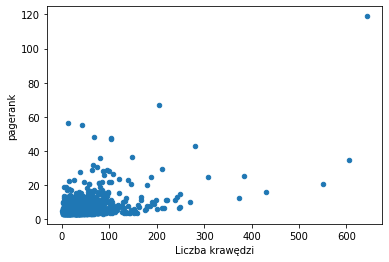

In [28]:
df = df_2.merge(df_1_reverse, how='inner', left_on='id', right_on='dst')
df.rename(columns = {'count(dst)' : 'Liczba krawędzi'}, inplace=True)
df.plot.scatter(x='Liczba krawędzi', y='pagerank')

## **Zadanie nr 4**

Korzystając z Pregel API zaimplementować następujący algorytm. W pierwszym kroku wybrana strona publikuje post fake news. W kolejnym kroku ten post publikowany jest przez 1/4 losowo wybranych kontaktów tej strony. W dalszych krokach, dla każdej strony, która opublikowała już ten post, losowo wybrane 1/4 jej kontaktów publikuje go u siebie. Pokazać jak zmienia się liczba stron które opublikowały post w zależności od liczby kroków.

In [150]:
from pyspark.sql.functions import coalesce, col, lit, sum, when, rand, min
import random

def get_publishers_number(graph: gf.GraphFrame, max_iter: int) -> pd.DataFrame:
  
  f = lambda x: 1 if x == True else 0
  g = lambda x: 1 if x>0 else 0

  fake_news = Pregel(graph)
  fake_news.setMaxIter(max_iter)
  fake_news.withVertexColumn("value", lit(1.0), fake_news.msg() * lit(f(0.25 > random.random())))
  fake_news.sendMsgToDst(fake_news.src("value"))
  fake_news.aggMsgs(sum(fake_news.msg()))

  result = fake_news.run()
  result = result.toPandas()

  print('Iterations are done!')

  return np.sum(result['value'].apply(g))


In [152]:
publisher_numbers = [get_publishers_number(graph, i) for i in range(1, 16)]

Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!
Iterations are done!


Zapisujemy uzyskane wartości do pliku .txt.

In [153]:
with open("publisher_numbers.txt", "w") as output:
    output.write(str(publisher_numbers))

In [154]:
publisher_numbers

[0, 0, 0, 15163, 14585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [156]:
steps = [_ for _ in range(1, 16)]
steps

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

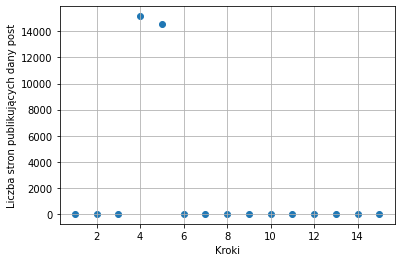

In [164]:
plt.scatter(steps, publisher_numbers)
plt.xlabel('Kroki')
plt.ylabel('Liczba stron publikujących dany post')
plt.grid()
plt.show()

## **Zadanie nr 5**

Narysować wykres rozkładu stopnia wierzchołków w grafie w skali logarytmicznej. Można skorzystać z funkcji obliczającej histogram dla RDD. Czy sieć jest bezskalowa (scale-free)? https://barabasi.com/f/623.pdf

In [50]:
degrees = sorted(list(graph.degrees.toPandas()['degree']), reverse=False)

In [51]:
rdd = sc.parallelize(degrees)

In [75]:
hist = rdd.histogram(max(degrees))
bins, values = hist

<ipython-input-76-d47209ca56dc>:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(bins[:-1]), np.log(values))


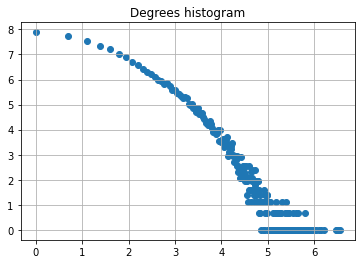

In [76]:
plt.scatter(np.log(bins[:-1]), np.log(values))
plt.grid()
plt.title('Degrees histogram')
plt.show()

W przybliżeniu sieć jest bezskalowa, ponieważ wykres wygląda w "przybliżeniu" na liniowy.